In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import DATA_DIR, FIGURE_DIR, ensure_dir
from childes_mi.utils.general import flatten,save_fig

In [3]:
from childes_mi.information_theory import model_fitting as mf

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
MI_DF = pd.read_pickle(DATA_DIR / "mi" / "phonbank_mi_french.pickle")

In [6]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,median_n_phones,shuffling
0,"[10.663371043816312, 10.245082225102422, 10.09...","[0.004945938272197813, 0.0048637140946431075, ...","[9.97526238326807, 9.974438705111332, 9.974402...","[0.004820450882092466, 0.004817713571462185, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,359954,0,1626,full
1,"[10.915505015310265, 10.548361851654079, 10.39...","[0.004887922729166499, 0.004802003833059679, 0...","[10.256572952023603, 10.25706837629712, 10.257...","[0.004749013927682985, 0.004750348844609571, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2.5,3,313197,0,1014,full
2,"[10.991623024066557, 10.646451779237823, 10.47...","[0.005196027243733277, 0.005117216935930317, 0...","[10.324423226440707, 10.325474461906364, 10.32...","[0.0050613373543492894, 0.005062582834832084, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2,2.5,277162,0,724,full


In [7]:
MI_DF.shuffling.unique()

array(['full'], dtype=object)

In [8]:
MI_DF = MI_DF.assign(**{i:np.nan for i in ['exp_results', 'pow_results', 'concat_results',
     'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
     'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak']})
MI_DF['curvature'] = MI_DF['curvature'].astype(object)

In [9]:
n = 100 # max distance for computation
for idx, row in tqdm(MI_DF.iterrows(), total=len(MI_DF)):
    # get signal
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    dist_mask = distances <= row.median_n_phones
    distances = distances[dist_mask]
    sig = sig[dist_mask]
    
    # fit models
    results_power, results_exp, results_pow_exp, best_fit_model = mf.fit_models(distances, sig)
    
    # get fit results
    R2_exp, R2_concat, R2_power, AICc_exp, \
        AICc_pow, AICc_concat = mf.fit_results(sig, distances, 
                                              results_exp, results_power,
                                              results_pow_exp)
    
    
    # get model y
    distances_mod = np.logspace(0,np.log10(n), base=10, num=1000)
    if best_fit_model == 'pow_exp':
        y_model = mf.get_y(mf.pow_exp_decay, results_pow_exp, distances_mod)
    elif best_fit_model == 'exp':
        y_model = mf.get_y(mf.exp_decay, results_exp, distances_mod)
    elif best_fit_model == 'pow':
        y_model = mf.get_y(mf.powerlaw_decay, results_power, distances_mod)
    
    # get curvature of model_y
    curvature_model = mf.curvature(np.log(y_model))
    
    # if the best fit model is pow_exp, then grab the min peak
    if best_fit_model == 'pow_exp':
        # get peaks of curvature
        peaks = np.where((
            (curvature_model[:-1] < curvature_model[1:])[1:] & (curvature_model[1:] < curvature_model[:-1])[:-1]
        ))
        min_peak = peaks[0][0]
    else:
        min_peak = np.nan

    # get save model fit results to MI_DF
    MI_DF.loc[idx, np.array(['exp_results', 'pow_results', 'concat_results',
                         'R2_exp', 'R2_concat', 'R2_power', 'AICc_exp',
                         'AICc_concat', 'AICc_power', 'bestfitmodel', 'curvature', 'min_peak'])] = [
        results_exp, results_power, results_pow_exp,
        R2_exp, R2_concat, R2_power, AICc_exp,
        AICc_concat, AICc_pow, best_fit_model,
        curvature_model, min_peak
    ]

    print(row.age_cohort_low, row.age_cohort_high, best_fit_model, row.shuffling)

/mnt/cube/tsainbur/Projects/github_repos/LRSO_paper_rev/LongRangeSequentialOrgPaper/childes_mi/information_theory/model_fitting.py:8: RuntimeWarning: invalid value encountered in log
  return np.abs(np.log(y_true) - np.log(y_model)) * (1 / (np.log(1 + x)))
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


3 20 pow_exp full
2.5 3 pow_exp full
2 2.5 pow_exp full
1.5 2 pow_exp full
1 1.5 pow_exp full
0.5 1 pow_exp full



In [10]:
MI_DF[:3]

,MI,MI_var,shuff_MI,shuff_MI_var,distances,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,median_n_phones,...,concat_results,R2_exp,R2_concat,R2_power,AICc_exp,AICc_concat,AICc_power,bestfitmodel,curvature,min_peak
0,"[10.663371043816312, 10.245082225102422, 10.09...","[0.004945938272197813, 0.0048637140946431075, ...","[9.97526238326807, 9.974438705111332, 9.974402...","[0.004820450882092466, 0.004817713571462185, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",3,20,359954,0,1626,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.807501,0.842233,0.841002,-6284.589532,-6588.379525,-6580.378123,pow_exp,"[-5.330335864094479e-06, -8.01638653847689e-06...",169.0
1,"[10.915505015310265, 10.548361851654079, 10.39...","[0.004887922729166499, 0.004802003833059679, 0...","[10.256572952023603, 10.25706837629712, 10.257...","[0.004749013927682985, 0.004750348844609571, 0...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2.5,3,313197,0,1014,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.924930,0.956229,0.955329,-5127.795729,-5670.767263,-5654.156368,pow_exp,"[-3.437157575260229e-06, -5.172210406077421e-0...",178.0
2,"[10.991623024066557, 10.646451779237823, 10.47...","[0.005196027243733277, 0.005117216935930317, 0...","[10.324423226440707, 10.325474461906364, 10.32...","[0.0050613373543492894, 0.005062582834832084, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",2,2.5,277162,0,724,...,<lmfit.minimizer.MinimizerResult object at 0x7...,0.965343,0.985488,0.984768,-4200.066287,-4826.277413,-4795.253824,pow_exp,"[-2.0121244236145916e-07, -3.1116095472584716e...",225.0


In [11]:
from matplotlib import gridspec

In [12]:
MI_DF_subset = MI_DF[MI_DF.shuffling == 'full']
len(MI_DF_subset)

6

### main decay

278 278
243 243
364 364


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old nam

724 724
1014 1014
1626 1626


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old nam

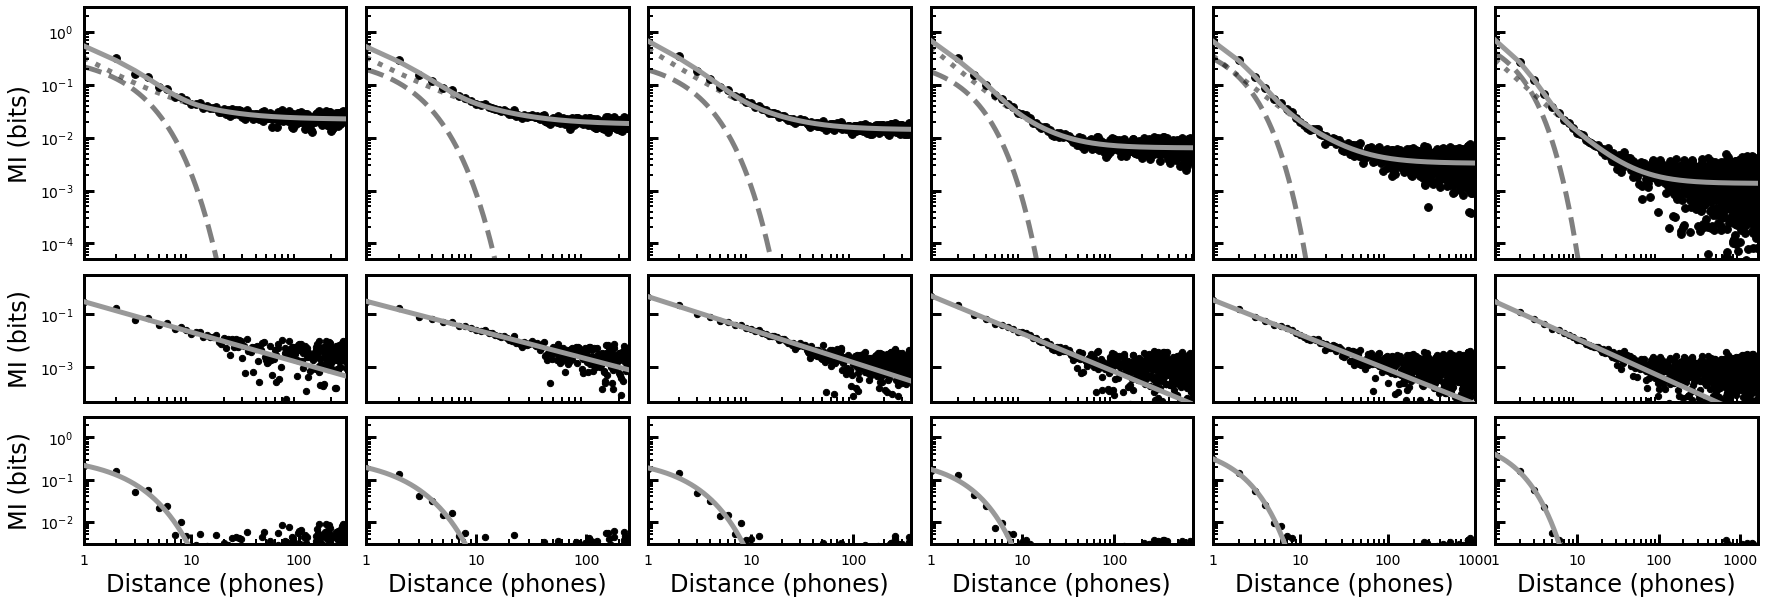

In [14]:
yoff=-.20
ncols = 4
zoom = 5
hr = [1, 0.5, 0.5, 0.5]
nrows = np.ceil(len(MI_DF_subset)/ncols).astype(int)
fig = plt.figure(figsize=(len(MI_DF_subset)*zoom,np.sum(hr)*zoom)) 
gs = gridspec.GridSpec(ncols=len(MI_DF_subset), nrows=4, height_ratios=hr) 

for axi, (idx, row) in enumerate(MI_DF_subset.sort_values(by=['age_cohort_low']).iterrows()):
    color = 'k'#LCOL_DICT[row.language]
    ax0 = plt.subplot(gs[0,axi])
    ax = ax0
    sig = np.array(row.MI-row.shuff_MI)
    distances = row.distances
    sig = sig
    
    
    dist_mask = distances <= row.median_n_phones
    distances = distances[dist_mask]
    sig = sig[dist_mask]
    print(row.median_n_phones, len(sig))
    
    # get signal limits
    sig_lims = np.log([np.min(sig[sig>0]), np.nanmax(sig)])
    sig_lims = [sig_lims[0] - (sig_lims[1]-sig_lims[0])/10,
                    sig_lims[1] + (sig_lims[1]-sig_lims[0])/10]
            
    if axi==0: 
            ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff,0.5)
            
    # model data
    #row.concat_results.params.intercept = 0
    distances_model = np.logspace(0,np.log10(distances[-1]), base=10, num=1000)
    y_model = mf.get_y(mf.pow_exp_decay, row.concat_results, distances)
    y_pow = mf.get_y(mf.powerlaw_decay, row.concat_results, distances_model)
    y_exp = mf.get_y(mf.exp_decay, row.concat_results, distances_model)
    y_pow_dat = mf.get_y(mf.powerlaw_decay, row.concat_results, distances)
    y_exp_dat = mf.get_y(mf.exp_decay, row.concat_results, distances)
    
    # plot real data
    ax.scatter(distances, sig, alpha = 1, s=60, color=color)   
    ax.plot(distances_model, y_pow, ls='dotted', color= 'k', lw=5, alpha=0.5)
    ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, ls='dashed', color= 'k', lw=5, alpha=0.5)
    
    # plot modelled data
    ax.plot(distances, y_model, alpha = 1, lw=5, color="#999999", zorder=10)
    
    # plot powerlaw component
    ax1 = plt.subplot(gs[1,axi])
    ax = ax1
    ax.plot(distances_model, y_pow-row.concat_results.params['intercept'].value, alpha = 1, lw=5, color="#999999", zorder=10)
    ax.scatter(distances, sig-y_exp_dat, alpha = 1, s=40, color=color)   
    
    # plot exponential component
    ax2 = plt.subplot(gs[2,axi])
    ax = ax2
    ax.plot(distances_model, y_exp-row.concat_results.params['intercept'].value, alpha = 1, lw=5, color="#999999", zorder=10)
    ax.scatter(distances, sig-y_pow_dat, alpha = 1, s=40, color=color)   
    
    

    ax.set_xlabel('Distance (phones)', labelpad=5, fontsize=24)
    #print(row.language, distances[peak_of_interest])
    
    for ax in [ax1, ax2]:
        if axi==0: 
            ax.set_ylabel('MI (bits)', labelpad=5, fontsize=24)
            ax.yaxis.set_label_coords(yoff,0.5)
    
    
    
    
    for ax in [ax0,ax1,ax2]:
        ax.set_xlim([distances[0], distances[-1]])
        sig_lims[0] = np.log(10e-6)
        ax.set_ylim([5e-5, 3])
        ax.tick_params(which='both', direction='in', labelsize=14, pad=10)
        ax.tick_params(which='major', length=10, width =3)
        ax.tick_params(which='minor', length=5, width =2)
        ax.set_xscale( "log" , basex=10)
        ax.set_yscale( "log" , basey=10)
        ax.set_xticks([])
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(3)
            ax.spines[axis].set_color('k')
    ax2.set_ylim([3e-3, 3])
    
    ax1.minorticks_on()
    
    xtick_list = [1,10, 100, 1000, 10000]
    xtick_list = [i for i in xtick_list if i <= row.median_n_phones]
    
    ax2.set_xticks(xtick_list)
    ax2.set_xticklabels([str(i) for i in xtick_list])
    
    ac_high = np.min([row.age_cohort_high, 4])
    #ax0.set_title("{} to {} years old".format(row.age_cohort_low, ac_high), fontsize=24)
    
    if axi !=0:
        for ax in [ax0,ax1,ax2]:
            ax.yaxis.set_ticklabels([])
            
gs.update(wspace=0.075, hspace=0.1)
    
save_fig(FIGURE_DIR/'phonbank_mi_components-french')